<a href="https://colab.research.google.com/github/Ness731/3-Min-Deeplearning/blob/main/Chapter_6_%EC%82%AC%EB%9E%8C%EC%9D%98_%EC%A7%80%EB%8F%84_%EC%97%86%EC%9D%B4_%ED%95%99%EC%8A%B5%ED%95%98%EB%8A%94_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필수 라이브러리 import
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [2]:
import matplotlib.pyplot as plt # 데이터 시각화
from mpl_toolkits.mplot3d import Axes3D # matpotlib에서 3차원의 plot을 그리는 용도
from matplotlib import cm # 데이터 포인트에 색상을 입히는 데 사용
import numpy as np # 행렬연산

In [3]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [5]:
# Fashion MNIST 데이터셋 로딩
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

torch.Size([64, 1, 28, 28])
torch.Size([64])


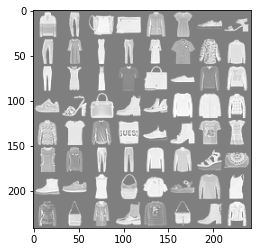

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

## 오토인코더(Autoencoder)
- __오토인코더의 정의__<br>
  __오토인코더(Autoencoder)__는 비지도(unsupervised)방식으로 훈련된 인공신경망으로, 먼저 데이터에 인코딩 된 표현을 학습한 다음, 학습된 인코딩 표현에서 입력 데이터와 최대한 가깝게 복원해내는 것을 목표로 한다.<br>

  _| 오토인코더의 출력 == 입력에 대한 예측 |_
  <br>

- __오토인코더의 구조__<br>
  오토인코더는 크게 __(1) 인코더 부분__과 __(2) 디코더 부분__으로 나눌 수 있다. <br>
  __1) 인코더(Encoder)__<br>
  입력 데이터와 동일한 차원으로 시작해서 점차 차원이 줄어드는 구조이며, 최종 출력 차원은 추출된 특징의 개수를 나타낸다.<br>
  __2) 디코더(Decoder)__<br>
  인코더를 거친 최종 데이터의 차원으로 시작해서 원본 입력 데이터와 동일한 차원으로 출력되는 구조로, 모델이 추출한 특징으로부터 원본 이미지를 복원하는 개념이다.<br>
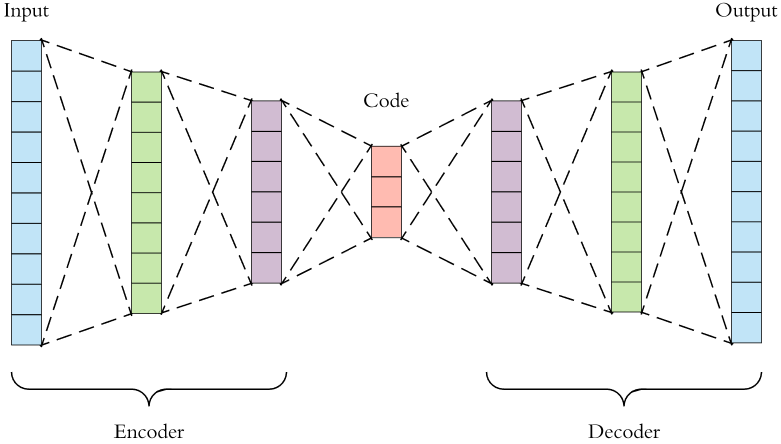

- __오토인코더 구현__<br>
  오토인코더 또한 이전에 구현했던 다른 신경망과 비슷한 구조를 가진다. 차이점은 encoder와 decoder의 두 신경망을 포함하고 있다는 것이다.<br>
  1) `__init__()`<br>
    초기화 함수에서는 신경망에서 사용할 모듈을 정의한다.
    - self.encoder
    - self.decoder
    - nn.Sequential() : 여러 개의 요소들로 이루어진 모듈을 순차적으로 실행하도록 담는 컨테이너 개념
    <br>

  2) `forward()`<br>
    초기화 함수에서 정의했던 `encoder`와 `decoder`를 이용하여 오토인코더의 연산 흐름을 정의한다.

In [7]:
# 오토인코더 구현부
class Autoencoder(nn.Module):
  # 초기화 함수
  def __init__(self):
    super(Autoencoder, self).__init__()
    # 초기화 함수에서는 인코더와 디코더를 정의한다.
    # Fasion Data: torch.Size([64, 1, 28, 28]) = 28*28 크기의 흑백 이미지가 64장 있음

    # 1. 인코더 - 점점 줄어드는 구조
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 128), # 입력층은 데이터 크기와 동일해야 함
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3), # 최종적으로 추출하는 feature은 3개
    )

    # 2. 디코더 - 점점 늘어나는 구조
    self.decoder = nn.Sequential(
        nn.Linear(3, 12), # 입력층은 인코더가 최종적으로 추출한 사이즈와 동일해야 함
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28 * 28), # 최종 출력은 입력 데이터 크기와 동일해야 함
        nn.Sigmoid(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [8]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.005)
criterion = nn.MSELoss()

In [9]:
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [14]:
def train(autoencoder, train_loader):
  autoencoder.train()
  for step, (x, label) in enumerate(train_loader):
    x = x.view(-1, 28*28).to(DEVICE) # 오토인코더는 input과 동일한 output을 생성해내는 것이 목표이므로
    y = x.view(-1, 28*28).to(DEVICE) # 종속변수와 독립변수의 표현방식이 동일하다.
    label = label.to(DEVICE)

    encoded, decoded = autoencoder(x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [15]:
for epoch in range(1, EPOCH+1):
  train(autoencoder, train_loader)

KeyboardInterrupt: ignored

In [ ]:
test_x = view_data.to(DEVICE)
_, decoded_data = autoencoder(test_x)

f, a = plt.subplots(2, 5, figsize = (5, 2))
print("[Epoch {}".format(epoch))
